In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import normalize, StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

import warnings
warnings.filterwarnings('ignore')

In [2]:
pd.set_option('display.float_format','{:.3f}'.format)

## CARGA Y EXPLORACIÓN DE DATOS

In [3]:
# Carga de datos
data = pd.read_csv('Superstore.csv', date_parser='Order Date')

In [4]:
# Datos de los consumidores
consumer_data = data[data.Segment=='Consumer']
consumer_data.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.960,2,0.000,41.914
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.940,3,0.000,219.582
3,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.577,5,0.450,-383.031
4,5,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.368,2,0.200,2.516
5,6,CA-2014-115812,6/9/2014,6/14/2014,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,FUR-FU-10001487,Furniture,Furnishings,Eldon Expressions Wood and Plastic Desk Access...,48.860,7,0.000,14.169


In [5]:
consumer_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5191 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         5191 non-null   int64  
 1   Order ID       5191 non-null   object 
 2   Order Date     5191 non-null   object 
 3   Ship Date      5191 non-null   object 
 4   Ship Mode      5191 non-null   object 
 5   Customer ID    5191 non-null   object 
 6   Customer Name  5191 non-null   object 
 7   Segment        5191 non-null   object 
 8   Country        5191 non-null   object 
 9   City           5191 non-null   object 
 10  State          5191 non-null   object 
 11  Postal Code    5191 non-null   int64  
 12  Region         5191 non-null   object 
 13  Product ID     5191 non-null   object 
 14  Category       5191 non-null   object 
 15  Sub-Category   5191 non-null   object 
 16  Product Name   5191 non-null   object 
 17  Sales          5191 non-null   float64
 18  Quantity

In [6]:
consumer_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Row ID,5191.000,4928.016,2883.398,1.000,2439.500,4859.000,7373.500,9994.000
Postal Code,5191.000,55649.896,31986.472,1453.000,23464.000,60201.000,90008.000,99301.000
Sales,5191.000,223.734,585.516,0.444,17.264,53.720,206.106,13999.960
Quantity,5191.000,3.761,2.207,1.000,2.000,3.000,5.000,14.000
Discount,5191.000,0.158,0.207,0.000,0.000,0.200,0.200,0.800
Profit,5191.000,25.837,242.594,-6599.978,1.584,8.375,28.607,6719.981


In [7]:
consumer_data.columns

Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit'],
      dtype='object')

## TRANSFORMACIONES DE DATOS

In [8]:
# Transformación de tipo de dato
consumer_data['Order Date'] = pd.to_datetime(consumer_data['Order Date'])

# Calculo de variable 'Discount'
consumer_data['Discount'] = consumer_data['Discount']  * consumer_data['Sales'] 

In [9]:
# Datos agrupados 
consumer = consumer_data.groupby(['Customer ID','Order ID','Order Date']).sum()
consumer.drop(['Row ID','Postal Code'], axis=1, inplace=True)
consumer = consumer.reset_index([0,1,2])

# Creo columna con las veces que cada cliente ha realizado compras
consumer['n_sales'] = consumer.groupby('Customer ID')['Order Date'].transform('count')


In [10]:
# Agrupar por Customer ID y seleccionar los valores de Order Date
consumer['CohortDay'] = consumer.groupby('Customer ID')['Order Date'].transform(min)

def get_date_int(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    day = df[column].dt.day
    return year, month, day

# Get the integers for date parts from the `InvoiceDay` column
order_year, order_month, order_day = get_date_int(consumer, 'Order Date')

# Get the integers for date parts from the `CohortDay` column
cohort_year, cohort_month, cohort_day = get_date_int(consumer, 'CohortDay')

# Calcula diferencia en años
years_diff = order_year - cohort_year

# Calcula dierencia en meses
months_diff = order_month - cohort_month

# Calcula diferencia en días
days_diff = order_day - cohort_day

# Crea variable con los días transcurrido desde la primera compra
consumer['CohortIndex'] = years_diff * 365 + months_diff * 30 + days_diff 

consumer = consumer.sort_values(by='Order Date')

# Crea variable con los días transcurridos desde la compra anterior
consumer['cohort_diff'] = consumer.groupby('Customer ID')['CohortIndex'].diff().fillna(0)

consumer

,Customer ID,Order ID,Order Date,Sales,Quantity,Discount,Profit,n_sales,CohortDay,CohortIndex,cohort_diff
736,DP-13000,CA-2014-103800,2014-01-03,16.448,2,3.290,5.551,9,2014-01-03,0,0.000
1590,MB-18085,CA-2014-141817,2014-01-05,19.536,3,3.907,4.884,7,2014-01-05,0,0.000
1550,LS-17230,CA-2014-130813,2014-01-06,19.440,3,0.000,9.331,3,2014-01-06,0,0.000
2542,VS-21820,CA-2014-105417,2014-01-07,87.158,10,54.381,-71.962,4,2014-01-07,0,0.000
1748,MS-17830,CA-2014-135405,2014-01-09,40.544,5,8.109,10.918,4,2014-01-09,0,0.000
...,...,...,...,...,...,...,...,...,...,...,...
1618,MC-17845,US-2017-102638,2017-12-29,6.030,3,0.000,2.955,7,2014-07-05,1269,19.000
1173,JG-15160,CA-2017-118885,2017-12-29,695.944,7,139.189,-21.598,11,2014-05-30,1304,134.000
338,BS-11755,CA-2017-130631,2017-12-29,88.060,7,0.000,30.142,7,2014-05-18,1316,96.000
1949,PO-18865,CA-2017-143259,2017-12-30,466.842,14,75.182,34.636,7,2014-03-23,1372,5.000


In [11]:
# Datos agrupados por 'Customer ID'
consumerID_data = consumer.groupby(by='Customer ID')[['Sales','n_sales','Discount','Profit','cohort_diff']].mean()

# Crea variable del número de veces que los clientes han comprado
#consumerID_data['n_sales'] = consumer.groupby('Customer ID')['Order ID'].count()

# Cantidad de productos comprado por cliente
consumerID_data['n_quantity'] = consumer.groupby('Customer ID')['Quantity'].sum()

consumerID_data.head()

,Sales,n_sales,Discount,Profit,cohort_diff,n_quantity
Customer ID,,,,,,
AA-10315,1112.712,5,203.186,-72.577,236.600,30
AA-10375,117.377,9,3.838,30.820,147.222,41
AA-10480,447.628,4,0.778,108.957,269.000,36
AA-10645,847.822,6,88.697,142.967,204.667,64
AB-10015,295.385,3,4.089,43.115,330.667,13


#### VARIABLES SIN ESCALADO

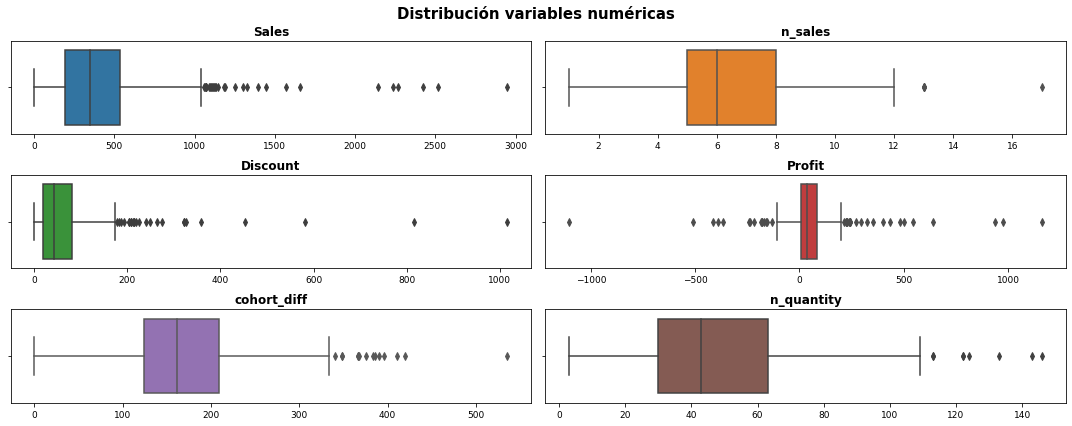

In [12]:
# DISTRIBUCIONES DE VARIABLES SIN ESCALAR
# ==============================================================================

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 6))
axes = axes.flat

numerical_features = [var for var in consumerID_data.select_dtypes(['float','int'])]

for i, feature in enumerate(numerical_features):
    sns.boxplot(
        data    = consumerID_data,
        x       = feature,
        color   = (list(plt.rcParams['axes.prop_cycle'])*2)[i]["color"],
        ax      = axes[i]
    )
    axes[i].set_title(feature, fontsize = 12, fontweight = "bold")
    axes[i].tick_params(labelsize = 9)
    axes[i].set_xlabel("")
    
    
fig.tight_layout()
plt.subplots_adjust(top = 0.9)
fig.suptitle('Distribución variables numéricas', fontsize = 15, fontweight = "bold");

#### ESCALADO DE VARIABLES

In [16]:
scaler_pipeline = ColumnTransformer(
                        transformers=[
                            ('robust_scaler', RobustScaler(), ['Sales','n_sales','cohort_diff','n_quantity'])
                        ]
)

# Escalado de variables
scaled_features = scaler_pipeline.fit_transform(consumerID_data)

# Variables escaladas - DataFrame
scaled_features = pd.DataFrame(scaled_features)

#### VARIABLES ESCALADAS

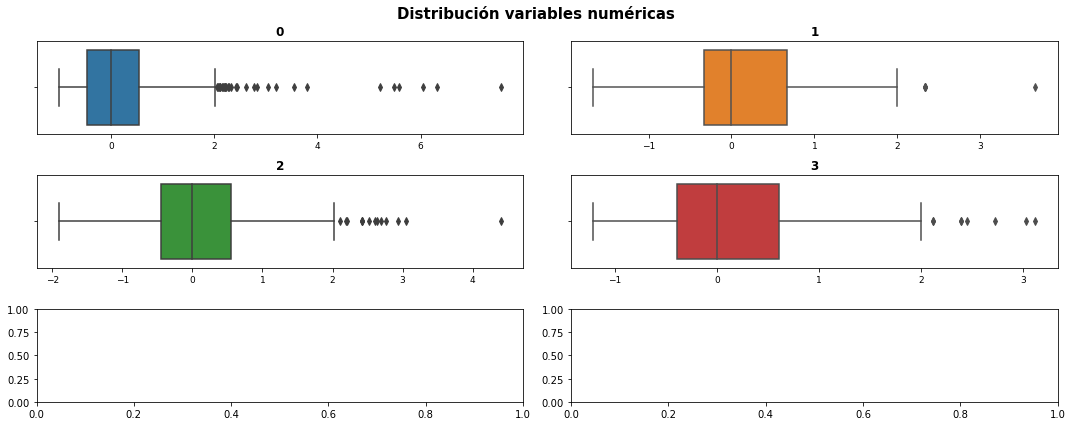

In [17]:
# DISTRIBUCIONES DE VARIABLES ESCALADAS
# ==============================================================================

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 6))
axes = axes.flat


for i, feature in enumerate(scaled_features.columns):
    sns.boxplot(
        data    = scaled_features,
        x       = feature,
        color   = (list(plt.rcParams['axes.prop_cycle'])*2)[i]["color"],
        ax      = axes[i]
    )
    axes[i].set_title(feature, fontsize = 12, fontweight = "bold")
    axes[i].tick_params(labelsize = 9)
    axes[i].set_xlabel("")
    
    
fig.tight_layout()
plt.subplots_adjust(top = 0.9)
fig.suptitle('Distribución variables numéricas', fontsize = 15, fontweight = "bold");

#### DIMENSIÓN INTRÍNSECA

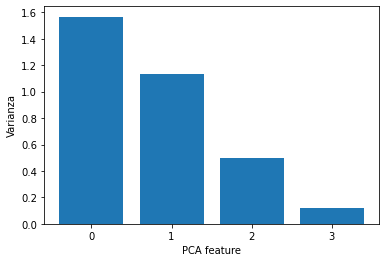

In [18]:
# DIMENSIÓN INTRÍNSECA DEL CONJUNTO DE DATOS
# =================================================================================

# Número de dimensiones en los datos
n_components = len(scaled_features)

# Instancia PCA
pca = PCA()

# Modelo entrenado
pca.fit(scaled_features)

# Visualización de las dimensiones intrínsecas
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_)
plt.xlabel('PCA feature')
plt.ylabel('Varianza')
plt.xticks(features)
plt.show()

In [26]:
# 

# Modelo 
pca2 = PCA(n_components=3)

# Componentes principales para entrenamiento
components = pca2.fit_transform(scaled_features)


## KMeans

#### MÉTODO DE CODO

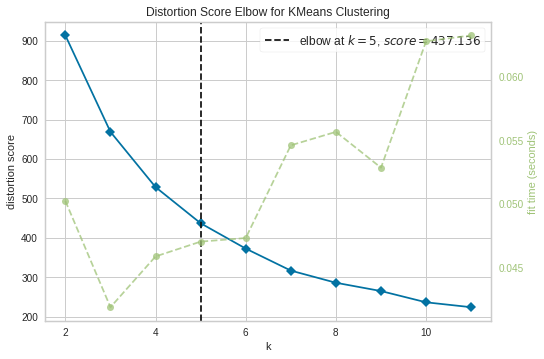

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [27]:
# MÉTODO DE CODO
# ============================================================================
from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.cluster import KElbowVisualizer


model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,12))

visualizer.fit(components)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure



#### ENTRENAMIENTO DEL MODELO - KMEANS

In [39]:
# Modelo - KMeans
kmeans_model = KMeans(n_clusters=5)

# Modelo entrenado
kmeans_model.fit_transform(components)

consumerID_data['cluster_labels'] = kmeans_model.labels_

kmeans_label_grouped = data_labeled.groupby('cluster_labels').mean()
kmeans_label_grouped[['Sales','n_sales','cohort_diff','n_quantity']] .T

cluster_labels,0,1,2,3,4
Sales,929.940,294.330,427.190,251.750,2314.146
n_sales,5.375,5.576,9.386,3.758,4.857
cohort_diff,169.615,158.984,126.075,299.290,165.155
n_quantity,51.429,35.429,76.123,24.968,56.000


In [36]:
# Copia de los datos de los consumidores
data_labeled = consumerID_data.copy()

# Asignación de las etiquetas de clusteres
silhouette_score(scaled_features, kmeans_model.labels_)



0.2997973707666705

<AxesSubplot:xlabel='cluster_labels'>

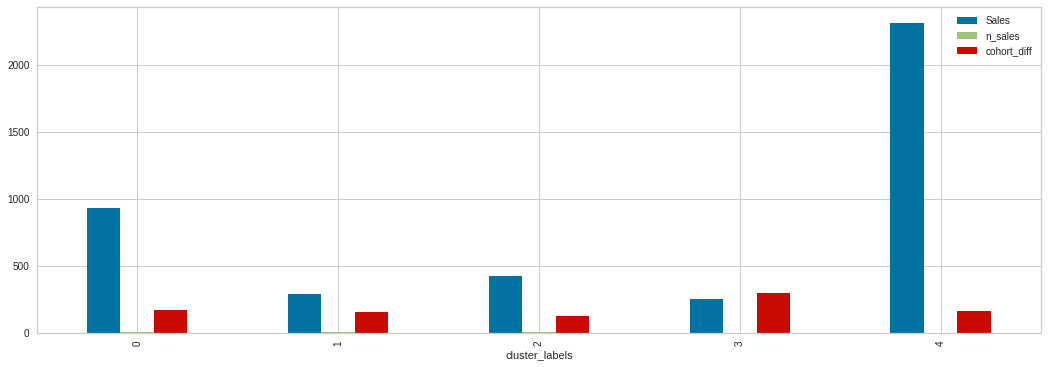

In [41]:
# Visualización de las medias de las variables por cluster
# ================================================================================

kmeans_label_grouped[['Sales','n_sales','cohort_diff']].plot(kind='bar', figsize=(18,6))

## Hierarchical Clustering

In [ ]:
# Modelo de segmentación jerárquica
hierarchy_model = linkage(scaled_features, method='ward')

In [ ]:
# Dendrograma
drendogram = dendrogram(model)

# Visualización del dendrograma
plt.show()

In [ ]:
# Punto de corte
cluster_labels = fcluster(hierarchy_model, 16, criterion='distance')

# Copia de los datos los consumidores
data_hierarchy = consumerID_data.copy()

# Asignación de las etiquetas de clusters a los datos
data_hierarchy['cluster_labels'] = cluster_labels


hierarchy_cluster_data = data_hierarchy.groupby('cluster_labels').mean()
hierarchy_cluster_data.T

In [ ]:
#fig , ax = plt.figure(figsize=(12,6))
hierarchy_cluster_data[['Sales','Profit']].plot(kind='bar', figsize=(18,6))